# Détection de tourbillons à partir de données de mouillages

Les données utilisées sont celles d'un mouillage. Pour détecter un tourbillon on utilise les maxima de vitesse liés à celui-ci.
On définit 3 couches dans lesquelles se situe les centres de différents type de tourbillons. Le travail décrit par la suite est effectué por chaque couche.


# Méthode

On cherche à identifier des valeurs extrêmes d'amplitude de vitesse. Pour cela on doit donc définir une vitesse de seuil.

Dans la première partie, on étudie la distribution de vitesse. Cette méthode étant peut efficace, on utilise dans la deuxième partie un clustering.

In [2]:
import sys
sys.path.append("/home/zoe/anaconda3/envs/arctic/lib/python3.6/site-packages/")
import numpy as np
from matplotlib import pyplot as plt
from netCDF4 import Dataset
from scipy.io import loadmat
import gsw
import seaborn as sns
from sklearn.mixture import GaussianMixture as GMM
from sklearn import preprocessing
import xarray as xr
import scipy.stats
import pandas as pd
%matplotlib inline

## Visualisation des données d'un mouillage sur 1 an

Le passage d'un tourbillon est marqué par des anomalies de température et de vitesse.

Text(0.5,0,'Temps')

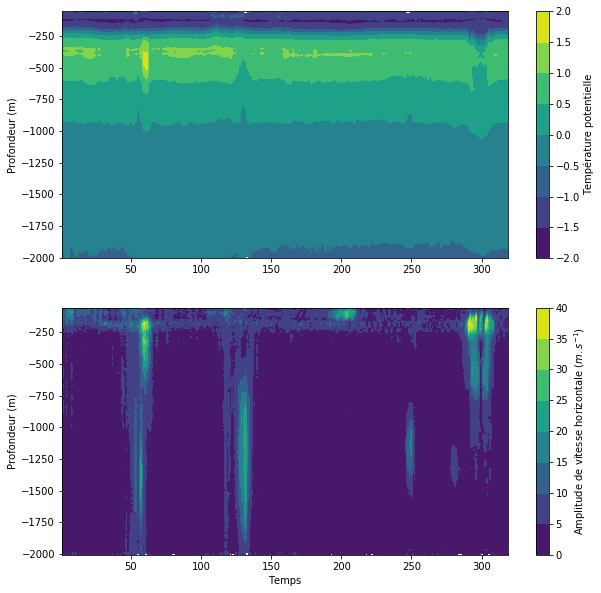

In [3]:
file="/home/zoe/Documents/Brest/Stage_M1/bg0304_mmp_b.mat"
f=loadmat(file)

#Sorties des différentes variables:

S=f['S'] #salinité
Th=f['THETA'] #Température potentielle
T=f['T'] #Tenpérature in situ
u=f['U'] #vitesse zonale
v=f['V'] #vitesse méridienne
t=f['TIME'] #temps
d=f['day'] #jours décimaux de l'année 2003
p=f['pgrid'] #pression
n=f['number'] #numéro des profils
loc=f['location'] #Emplacement du mouillage

P,N=np.meshgrid(p,n)
z=-1*p.T #Profondeur
U=np.sqrt(u**2+v**2) #amplitude de vitesse

#visualisation des données:

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.contourf(N,-1*P,Th,cmap='viridis');plt.colorbar(label='Température potentielle')
plt.ylabel('Profondeur (m)')
plt.subplot(2,1,2)
plt.contourf(N,-1*P,U,cmap='viridis');plt.colorbar(label='Amplitude de vitesse horizontale $(m.s^{-1})$')
plt.ylabel('Profondeur (m)');plt.xlabel('Temps')

Le passage des tourbillons est meux marqué par les maxima d'amplitude de vitesse. Ce sont donc ces données que l'ont utilisera par la suite.

On ne s'intéresse pas aux tourbillons de surface. Dans cette zone les tourbillons de moyenne profondeur ( middepth) présentent 2 noyaux (liés à 2 maxima de vitesse) . On définit donc 3 couches: 1 pour chaque noyau des tourbillons middepth et 1 pour les tourbillons profonds.

In [5]:
#Moyenne vitesse dans la couche 1 (-150/-260), tourbillons middepth, noyau shallow:
zl1=-151
zl2=-261
il1=np.where(z==zl1)[0][0]
il2=np.where(z==zl2)[0][0]

um1=np.nanmean(u[:,il1:il2],axis=1)
vm1=np.nanmean(v[:,il1:il2],axis=1)
T1=np.nanmean(T[:,il1:il2],axis=1)
Um1=np.sqrt(um1**2+vm1**2)

#Moyenne dans la couche 2 (-300/-600), tourbillons mid-depth, noyau profond:
zL1=-301
zL2=-601
iL1=np.where(z==zL1)[0][0]
iL2=np.where(z==zL2)[0][0]

um2=np.nanmean(u[:,iL1:iL2],axis=1)
vm2=np.nanmean(v[:,iL1:iL2],axis=1)
T2=np.nanmean(T[:,iL1:iL2],axis=1)
Um2=np.sqrt(um2**2+vm2**2)

#Moyenne dans la couche 3 (-900/-1600), tourbillons profonds:
zD1=-901
zD2=-1601
iD1=np.where(z==zD1)[0][0]
iD2=np.where(z==zD2)[0][0]

um3=np.nanmean(u[:,iD1:iD2],axis=1)
vm3=np.nanmean(v[:,iD1:iD2],axis=1)
T3=np.nanmean(T[:,iD1:iD2],axis=1)
Um3=np.sqrt(um3**2+vm3**2)

## Definition d'une valeur d'amplitude de vitesse seuil par l'étude de la distribution

1$^{ère}$ étape: 
Etude de la distribution de l'amplitude de vitesse

/home/zoe/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'PDF couche 3')

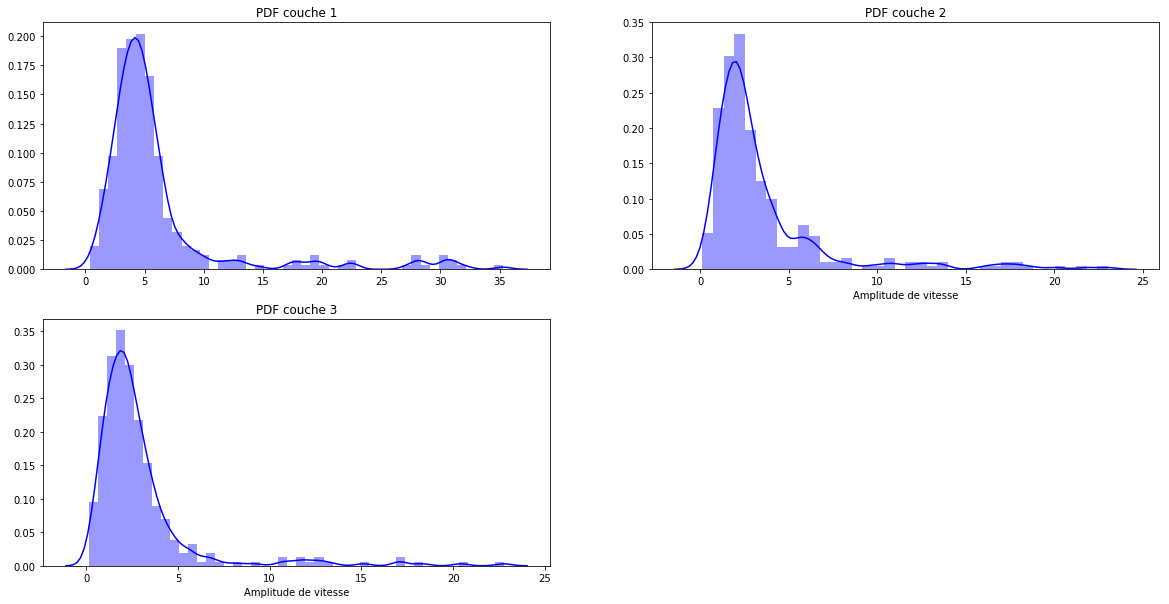

In [6]:
#Distribution de l'amplitude de vitesse moyenne dans chaque couche:

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
c1=sns.distplot(Um1, norm_hist=True, color="b");plt.title('PDF couche 1')
plt.subplot(2,2,2)
c2=sns.distplot(Um2, norm_hist=True, color="b");plt.xlabel('Amplitude de vitesse');plt.title('PDF couche 2')
plt.subplot(2,2,3)
c3=sns.distplot(Um3, norm_hist=True, color="b");plt.xlabel('Amplitude de vitesse');plt.title('PDF couche 3')

2$^{ème}$ étape: Fit des données à une distribution

On doit utiliser une distribution pour des données bornées (amplitude de vitesse positive)

/home/zoe/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'PDF couche 3')

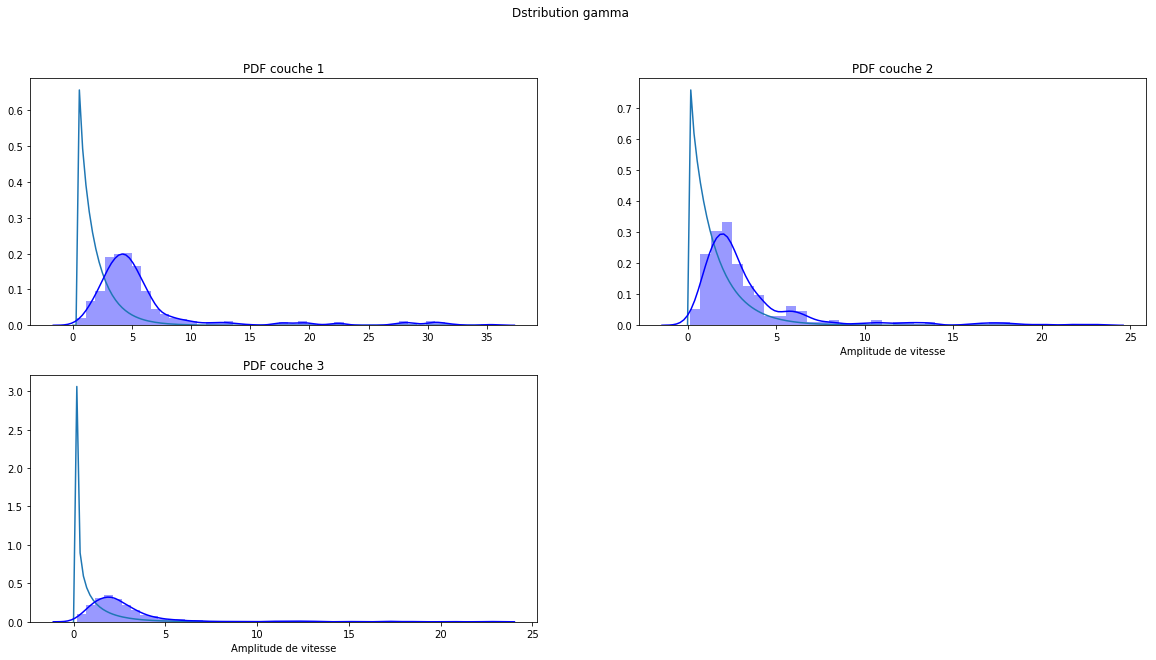

In [7]:
#Fit gamma ditribution:

#Couche 1:
x1=np.linspace(0,np.max(Um1),128)
param1=scipy.stats.gamma.fit(Um1)  #Cacul paramètre fit
pdf1=scipy.stats.gamma.pdf(x1,*param1)

#Couche 2:
x2=np.linspace(0,np.max(Um2),128)
param2=scipy.stats.gamma.fit(Um2)
pdf2=scipy.stats.gamma.pdf(x2,*param2)

#Couche3:
x3=np.linspace(0,np.max(Um3),128)
param3=scipy.stats.gamma.fit(Um3)
#fitness = scipy.stats.kstest(Um1,'gamma',args=para)
#print(fitness)
pdf3=scipy.stats.gamma.pdf(x3,*param3)

#Visualisation PDF:
plt.figure(figsize=(20,10))
plt.suptitle('Dstribution gamma')
plt.subplot(2,2,1)
plt.plot(x1,pdf1)
sns.distplot(Um1, norm_hist=True, color="b");plt.title('PDF couche 1')
plt.subplot(2,2,2)
plt.plot(x2,pdf2)
sns.distplot(Um2, norm_hist=True, color="b");plt.xlabel('Amplitude de vitesse');plt.title('PDF couche 2')
plt.subplot(2,2,3)
plt.plot(x3,pdf3)
sns.distplot(Um3, norm_hist=True, color="b");plt.xlabel('Amplitude de vitesse');plt.title('PDF couche 3')

Visiblement, ce n'est pas concluant, la fonction gamma gère mal la borne en 0.

On essaie pour 2 autres ditributions: beta et Weibull

/home/zoe/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/zoe/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/zoe/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


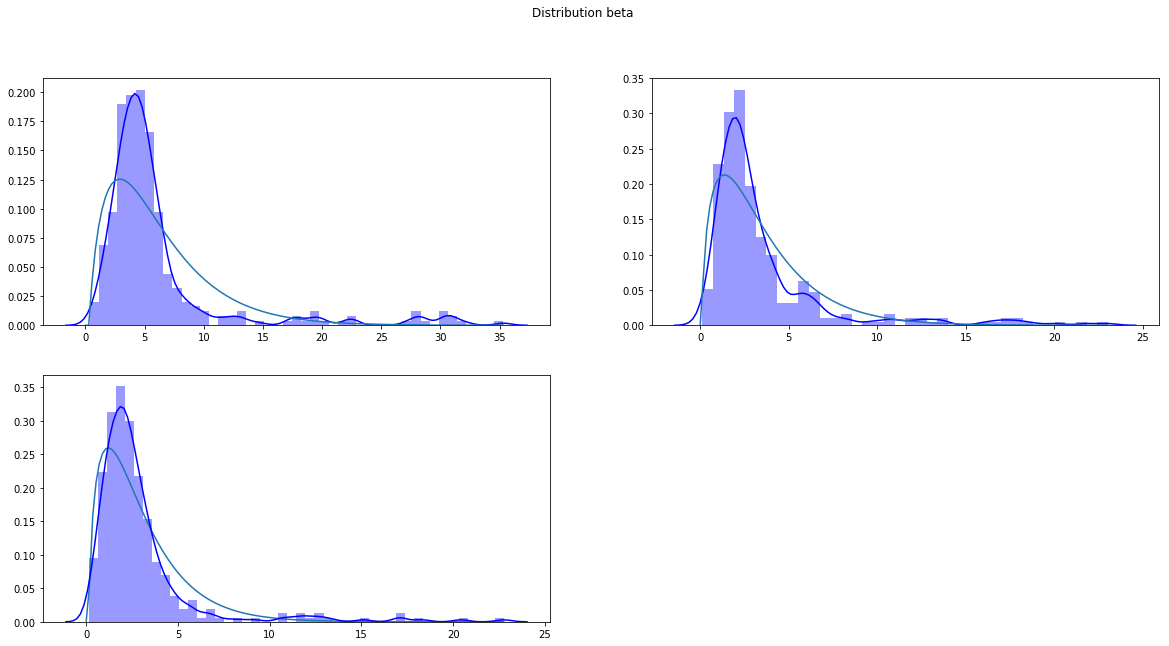

In [10]:
#Fit beta ditrib

#Couche1:
x1=np.linspace(0,np.max(Um1),128)
param1=scipy.stats.beta.fit(Um1)
pdf1=scipy.stats.beta.pdf(x1,*param1)

#Couche2:
x2=np.linspace(0,np.max(Um2),128)
param2=scipy.stats.beta.fit(Um2)
pdf2=scipy.stats.beta.pdf(x2,*param2)

#Couche3:
x3=np.linspace(0,np.max(Um3),128)
param3=scipy.stats.beta.fit(Um3)
pdf3=scipy.stats.beta.pdf(x3,*param3)


plt.figure(figsize=(20,10))
plt.suptitle('Distribution beta')
plt.subplot(2,2,1)
sns.distplot(Um1, norm_hist=True, color="b")
plt.plot(x1,pdf1)
plt.subplot(2,2,2)
sns.distplot(Um2, norm_hist=True, color="b")
plt.plot(x2,pdf2)
plt.subplot(2,2,3)
plt.plot(x3,pdf3)
sns.distplot(Um3, norm_hist=True, color="b")

/home/zoe/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


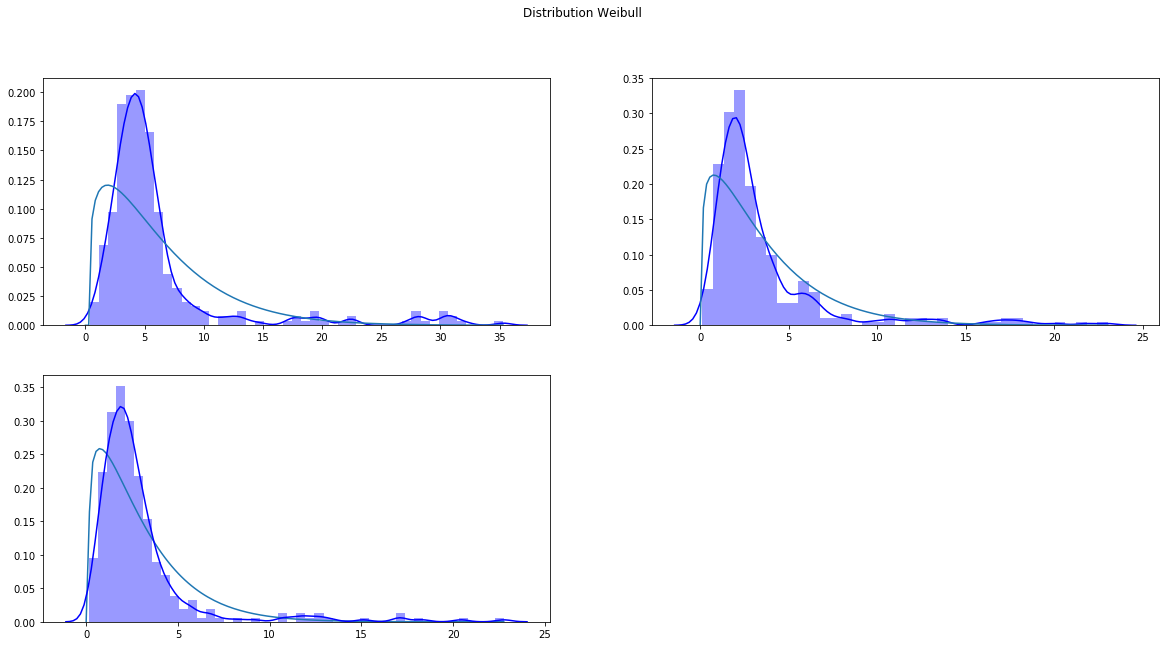

In [9]:
#Fit weibull distrib:

#Couche1:
x1=np.linspace(0,np.max(Um1),128)
param1=scipy.stats.weibull_min.fit(Um1)
pdf1=scipy.stats.weibull_min.pdf(x1,*param1)

#Couche2:
x2=np.linspace(0,np.max(Um2),128)
param2=scipy.stats.weibull_min.fit(Um2)
pdf2=scipy.stats.weibull_min.pdf(x2,*param2)

#Couche3:
x3=np.linspace(0,np.max(Um3),128)
param3=scipy.stats.weibull_min.fit(Um3)
pdf3=scipy.stats.weibull_min.pdf(x3,*param3)

plt.figure(figsize=(20,10))
plt.suptitle('Distribution Weibull')
plt.subplot(2,2,1)
sns.distplot(Um1, norm_hist=True, color="b")
plt.plot(x1,pdf1)
plt.subplot(2,2,2)
sns.distplot(Um2, norm_hist=True, color="b")
plt.plot(x2,pdf2)
plt.subplot(2,2,3)
plt.plot(x3,pdf3)
sns.distplot(Um3, norm_hist=True, color="b")

On ne peut pas fitter efficacement la distribution des vitesse à une distribution bornée en 0.
Nous allons donc définir une amplitude vitesse seuil visuellement.
Au-dessus de cette vitesse limite on considèrera l'amplitude de vitesse associée à une anomalie (tourbillon).

Text(0.5,1,'Couche 2')

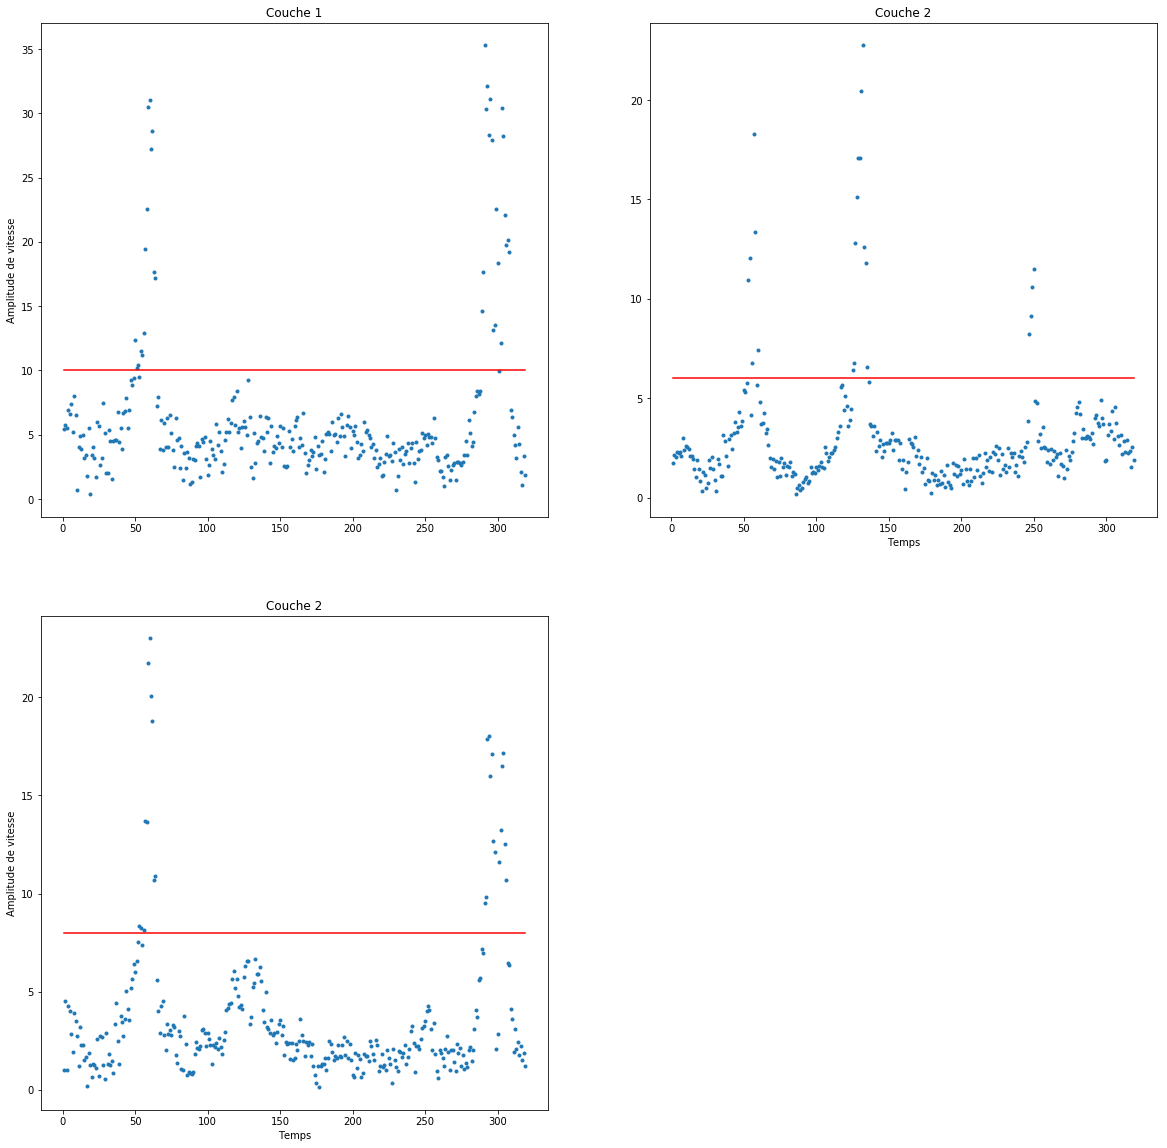

In [16]:
#Vitesses seuil par couche:
U_seuil1=10
U_seuil2=8
U_seuil3=6

#Visualistation anomalies:

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.plot(n,Um1,'.')
plt.plot(n,U_seuil1*np.ones(n.size),'r');plt.ylabel('Amplitude de vitesse')
plt.title('Couche 1')
plt.subplot(2,2,3)
plt.plot(n,Um2,'.')
plt.plot(n,U_seuil2*np.ones(n.size),'r');plt.ylabel('Amplitude de vitesse');plt.xlabel('Temps')
plt.title('Couche 2')
plt.subplot(2,2,2)
plt.plot(n,Um3,'.')
plt.plot(n,U_seuil3*np.ones(n.size),'r');plt.xlabel('Temps')
plt.title('Couche 2')

On peut alors definir les tableaux de vitesses des tourbillons et les index de temps correspondant.

In [17]:
#Vitesses anormales pour chaque couche et leur index:
U1ano=Um1[Um1>U_seuil1]
i1ano=np.where(Um1>U_seuil1)[0]
U2ano=Um2[Um2>U_seuil2]
i2ano=np.where(Um2>U_seuil2)[0]
U3ano=Um1[Um3>U_seuil3]
i3ano=np.where(Um3>U_seuil3)[0]

## Clustering

On cherche maintenant une autre méthode moins subjective de définir une valeur de vitesse seuil et donc de définir le passage d'un tourbillon. Pour cela il faut une grandeur (autre que la vitesse) qui permettrait de détecter un tourbillon et donc de repèrer les tourbillons par clustering. La phase des vecteurs vitesse est une possibilité. 

Text(0.5,0,'Temps')

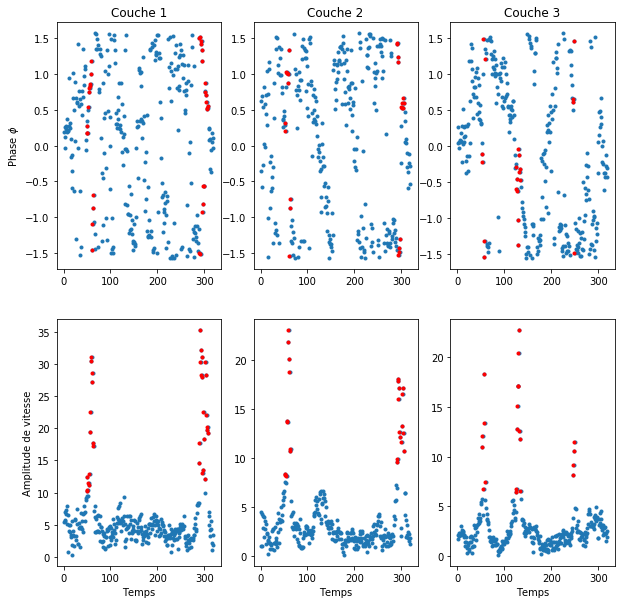

In [24]:
#Phase par couche:

phi1 = np.arctan(vm1/um1)
phi2 = np.arctan(vm2/um2)
phi3 = np.arctan(vm3/um3)


plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.plot(n,phi1,'.')
plt.plot(i1ano,phi1[i1ano],'r.');plt.ylabel('Phase $\phi$');plt.title('Couche 1')
plt.subplot(2,3,4)
plt.plot(n,Um1,'.')
plt.ylabel('Amplitude de vitesse');plt.xlabel('Temps')
plt.plot(i1ano,Um1[i1ano],'r.')
plt.subplot(2,3,2)
plt.plot(n,phi2,'.')
plt.plot(i2ano,phi2[i2ano],'r.');plt.title('Couche 2')
plt.subplot(2,3,5)
plt.plot(n,Um2,'.')
plt.plot(i2ano,Um2[i2ano],'r.');plt.xlabel('Temps')
plt.subplot(2,3,3)
plt.plot(n,phi3,'.')
plt.plot(i3ano,phi3[i3ano],'r.');plt.title('Couche 3')
plt.subplot(2,3,6)
plt.plot(n,Um3,'.')
plt.plot(i3ano,Um3[i3ano],'r.');plt.xlabel('Temps')

A priori ça ne parait pas concluant. On effectue alors une rotation du repère des vitesses et on regarde une différence des phases avec une phase d'advection.

Text(0.5,0.98,'Couche 1')

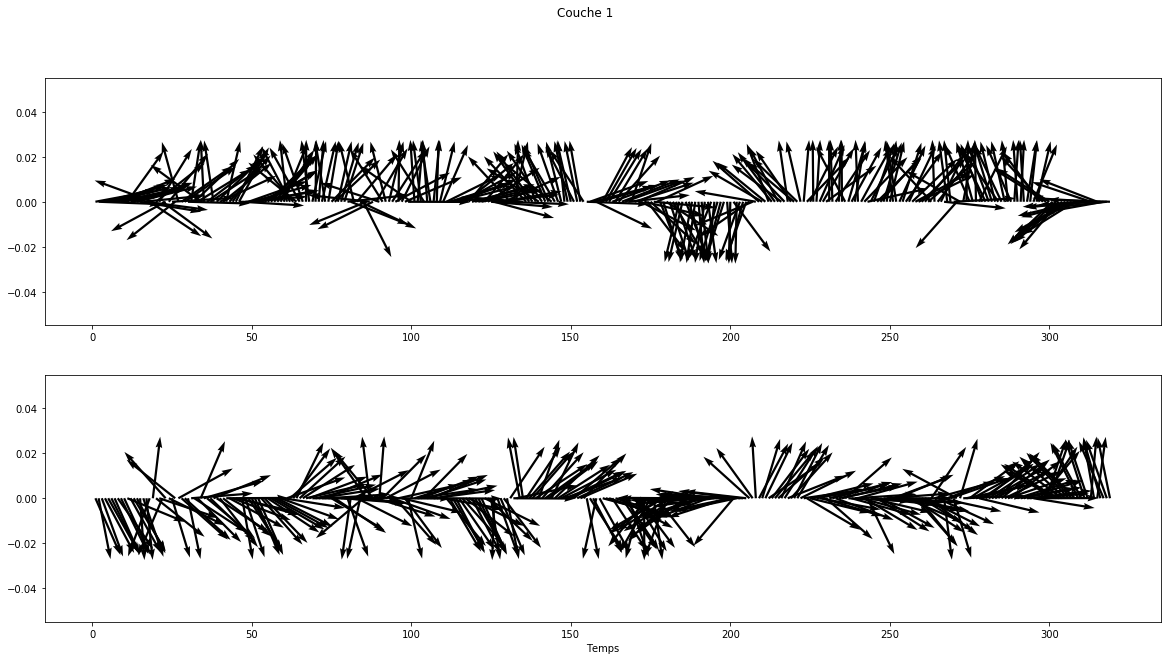

In [25]:
#Couche 1:
uadv1=np.mean(um1)
vadv1=np.mean(vm1)

phiadv1=np.arctan(vadv1/uadv1)
ur1=np.cos(phiadv1)*um1+np.sin(phiadv1)*vm1
vr1=np.cos(phiadv1)*vm1-np.sin(phiadv1)*um1
Ur1=np.sqrt(ur1**2+vr1**2)

Phi1=-np.arctan(vr1/ur1)+phiadv1

#Visualisation des vecteurs vitesse avant et après rotation:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
for i in range(np.size(ur1)):
    plt.quiver(n[i],0,um1[i],vm1[i],width=0.002)
plt.subplot(2,1,2)
for i in range(np.size(ur1)):
    plt.quiver(n[i],0,ur1[i],vr1[i],width=0.002)
plt.xlabel('Temps')
plt.suptitle('Couche 1')

Text(0.5,0.98,'Couche 2')

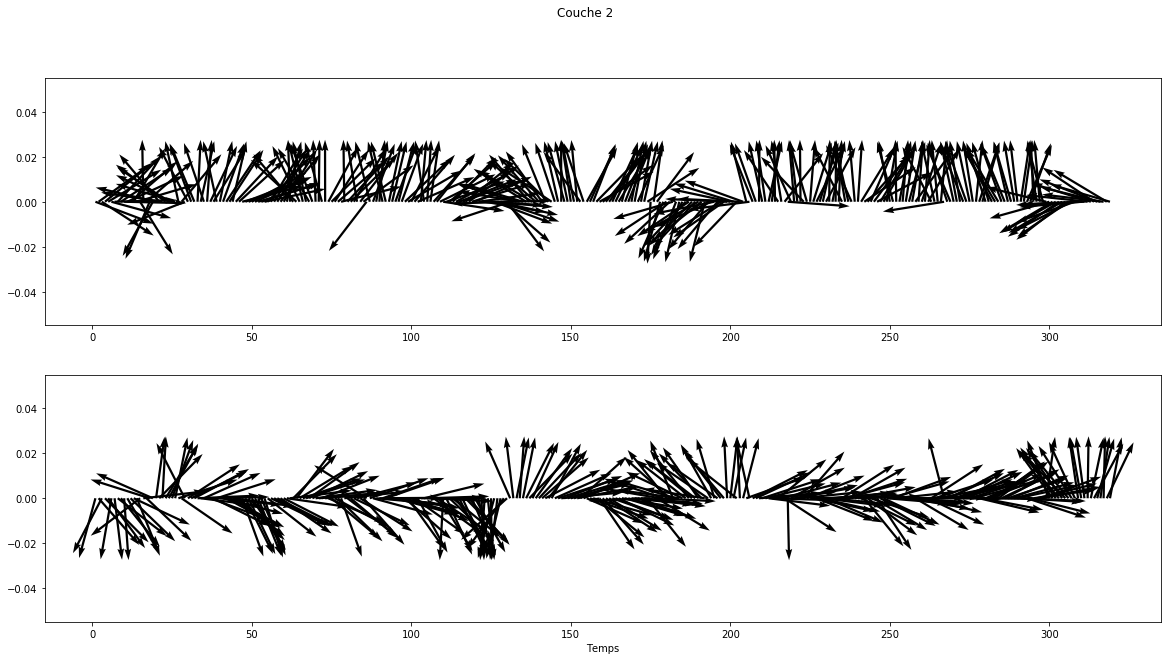

In [27]:
#Couche 2:
uadv2=np.mean(um2)
vadv2=np.mean(vm2)
phiadv2=np.arctan(vadv2/uadv2)
ur2=np.cos(phiadv2)*um2+np.sin(phiadv2)*vm2
vr2=np.cos(phiadv2)*vm2-np.sin(phiadv2)*um2
Ur2=np.sqrt(ur2**2+vr2**2)

Phi2=-np.arctan(vr2/ur2)+phiadv2

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
for i in range(np.size(ur2)):
    plt.quiver(n[i],0,um2[i],vm2[i],width=0.002)
plt.subplot(2,1,2)
for i in range(np.size(ur2)):
    plt.quiver(n[i],0,ur2[i],vr2[i],width=0.002)
plt.xlabel('Temps')
plt.suptitle('Couche 2')

Text(0.5,0.98,'Couche 3')

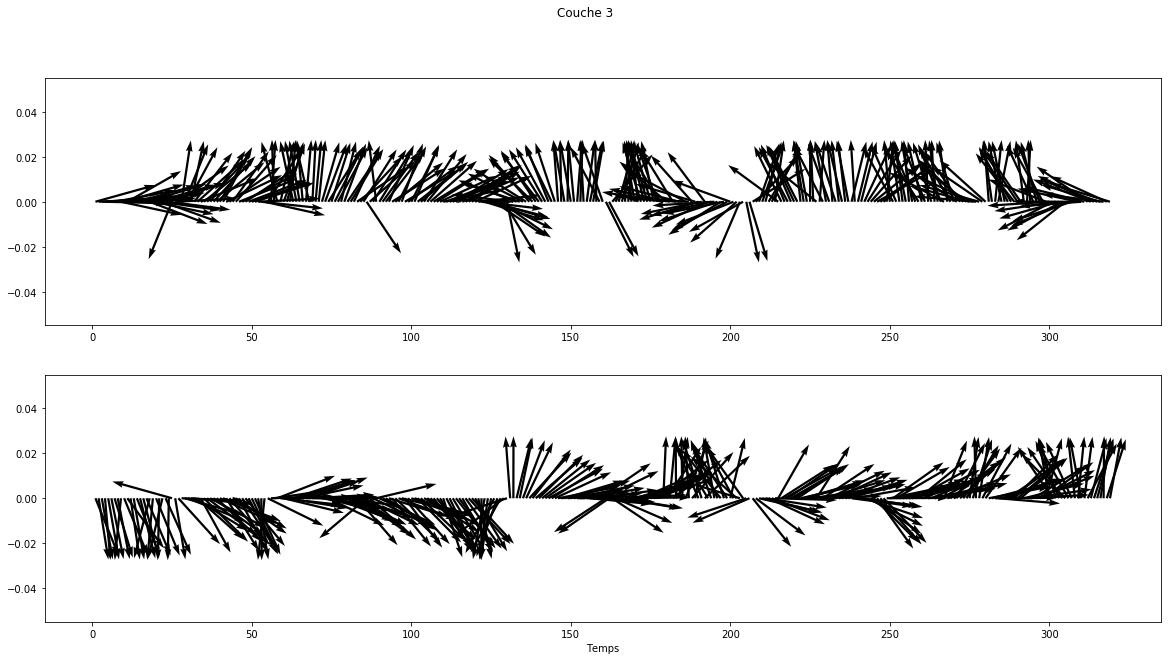

In [28]:
#Couche 3:
uadv3=np.mean(um3)
vadv3=np.mean(vm3)
phiadv3=np.arctan(vadv3/uadv3)
ur3=np.cos(phiadv3)*um3+np.sin(phiadv3)*vm3
vr3=np.cos(phiadv3)*vm3-np.sin(phiadv3)*um3
Ur3=np.sqrt(ur3**2+vr3**2)

Phi3=-np.arctan(vr3/ur3)+phiadv3

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
for i in range(np.size(ur3)):
    plt.quiver(n[i],0,um3[i],vm3[i],width=0.002)
plt.subplot(2,1,2)
for i in range(np.size(ur3)):
    plt.quiver(n[i],0,ur3[i],vr3[i],width=0.002)

plt.xlabel('Temps')
plt.suptitle('Couche 3')

Text(0.5,0,'Phase $\\phi$')

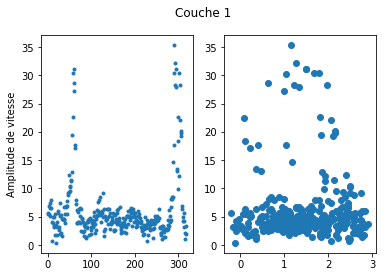

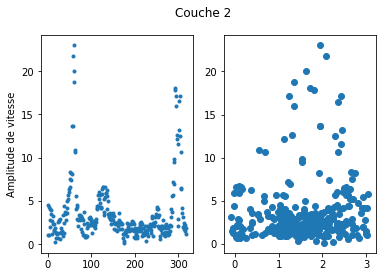

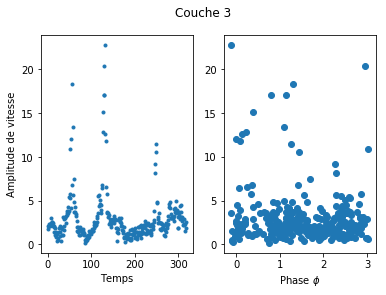

In [29]:
#Scatter plot des amplitudes de vitesse et des phases

plt.subplot(1,2,1)
plt.plot(Ur1,'.');plt.ylabel('Amplitude de vitesse')
plt.subplot(1,2,2)
plt.scatter(Phi1,Ur1);plt.suptitle('Couche 1')
plt.figure()
plt.subplot(1,2,1)
plt.plot(Ur2,'.');plt.ylabel('Amplitude de vitesse')
plt.subplot(1,2,2)
plt.scatter(Phi2,Ur2);plt.suptitle('Couche 2')
plt.figure()
plt.subplot(1,2,1)
plt.plot(Ur3,'.');plt.ylabel('Amplitude de vitesse');plt.xlabel('Temps')
plt.subplot(1,2,2)
plt.scatter(Phi3,Ur3);plt.suptitle('Couche 3');plt.xlabel('Phase $\phi$')

On effectue un clustering avec $\phi$ et l'amplitude de vitesse. On commence avec 2 clusters puisqu'on cherche l'état du courant poyen et les anomalies liées aux tourbillons.

CPU times: user 10.4 ms, sys: 48 µs, total: 10.4 ms
Wall time: 9.63 ms


Text(0.5,0,'Temps')

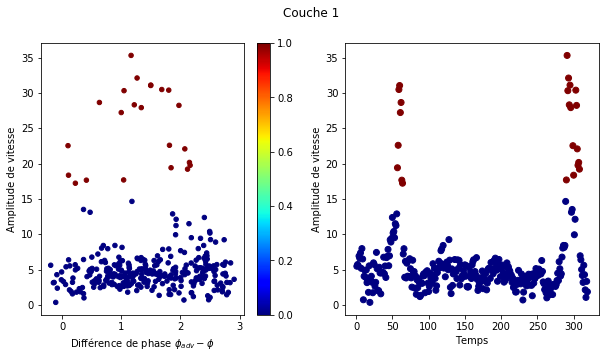

In [34]:
from sklearn.cluster import KMeans
phi_1=xr.DataArray(Phi1)
U_r1=xr.DataArray(Ur1)
D1=np.array((Phi1,Ur1)).T

%time kmeans = KMeans(n_clusters=2, random_state=0).fit(D1)
labels = kmeans.predict(D1)
n_clusters_ = kmeans.n_clusters
kmeans.cluster_centers_.shape

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sc=plt.scatter(D1[:,0],D1[:,1],s=20,c=labels,cmap='jet')
plt.colorbar(sc)
plt.suptitle('Couche 1')
plt.xlabel('Différence de phase $\phi_{adv}-\phi$')
plt.ylabel('Amplitude de vitesse')
plt.subplot(1,2,2)
sc=plt.scatter(n,Ur1,c=labels,cmap='jet');plt.ylabel('Amplitude de vitesse');plt.xlabel('Temps')

CPU times: user 13.7 ms, sys: 35 µs, total: 13.8 ms
Wall time: 13.1 ms


Text(0.5,0,'Temps')

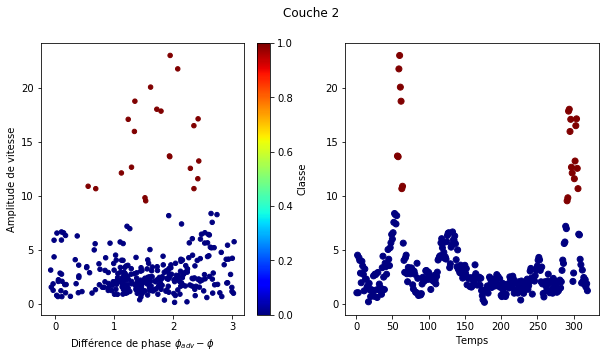

In [32]:
D2=np.array((Phi2,Ur2)).T
%time kmeans = KMeans(n_clusters=2, random_state=0).fit(D2)
labels2 = kmeans.predict(D2)
n_clusters_ = kmeans.n_clusters
kmeans.cluster_centers_.shape
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sc2=plt.scatter(D2[:,0],D2[:,1],s=20,c=labels2,cmap='jet')
plt.colorbar(sc2,label='Classe')
plt.suptitle('Couche 2')
plt.xlabel('Différence de phase $\phi_{adv}-\phi$')
plt.ylabel('Amplitude de vitesse')
plt.subplot(1,2,2)
sc2=plt.scatter(n,Ur2,c=labels2,cmap='jet');plt.xlabel('Temps')

CPU times: user 9.95 ms, sys: 40 µs, total: 9.99 ms
Wall time: 9.46 ms


Text(0.5,0,'Temps')

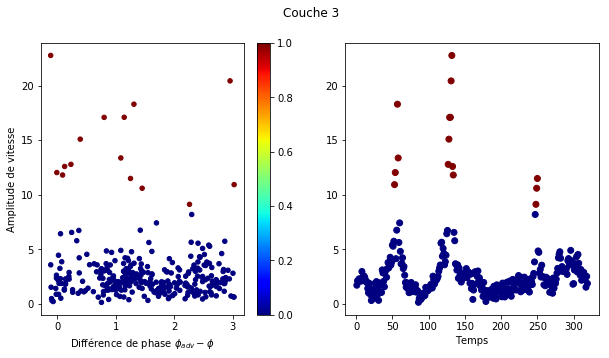

In [36]:
D3=np.array((Phi3,Ur3)).T
%time kmeans = KMeans(n_clusters=2, random_state=0).fit(D3)
labels3 = kmeans.predict(D3)
n_clusters_ = kmeans.n_clusters
kmeans.cluster_centers_.shape

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sc3=plt.scatter(D3[:,0],D3[:,1],s=20,c=labels3,cmap='jet')
plt.colorbar(sc3)
plt.suptitle('Couche 3')
plt.xlabel('Différence de phase $\phi_{adv}-\phi$')
plt.ylabel('Amplitude de vitesse')
plt.subplot(1,2,2)
sc3=plt.scatter(n,Ur3,c=labels3,cmap='jet');plt.xlabel('Temps')

La méthode Kmeans 2 cluster semble bien performant dans notre cas et permet d'identifier les anomalies pour les 3 couches. Pour définir une vitesse moyenne (vitesse d'advection), on peut utiliser cette méthode mais pour 3 clusters, ce qui permet d'identifier les vitesses extrêmes, un cluster intermédiaire de "bruit", et une vitesse moyenne.

CPU times: user 20.8 ms, sys: 0 ns, total: 20.8 ms
Wall time: 20.1 ms


Text(0.5,0,'Temps')

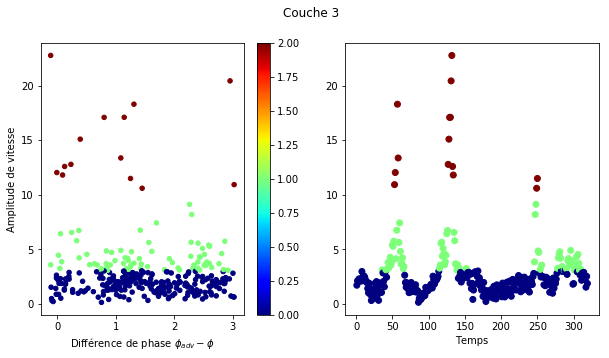

In [38]:
%time kmeans = KMeans(n_clusters=3, random_state=0).fit(D3)
labels3 = kmeans.predict(D3)
n_clusters_ = kmeans.n_clusters
kmeans.cluster_centers_.shape

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sc3=plt.scatter(D3[:,0],D3[:,1],s=20,c=labels3,cmap='jet')
plt.colorbar(sc3)
plt.suptitle('Couche 3')
plt.xlabel('Différence de phase $\phi_{adv}-\phi$')
plt.ylabel('Amplitude de vitesse')
plt.subplot(1,2,2)
sc3=plt.scatter(n,Ur3,c=labels3,cmap='jet');plt.xlabel('Temps')

On le fait ici pour la couche 3 où les vitesse sont situées majoritairement entre 0 et 3m$s^{-1}$. Cette vitesse d'advection permettrait par la suite de calculer de échelles de longueur des tourbillons.

## Bonus: GMM


Posteriors for 1 sample: [[ 5.29 94.71]] in %
Sum of the posteriors: 1.0000000000000004
Class id of the sample: [1]


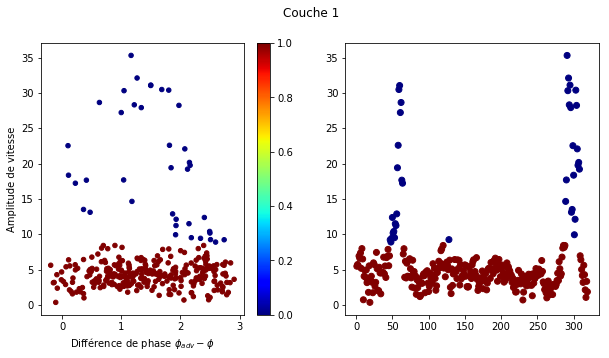

In [41]:
K=2

# Init the GMM
gmm1=GMM(n_components=K)

# Fit the GMM onto the dataset
gmm1=gmm1.fit(D1)
# Get the posteriors
posts1=gmm1.predict_proba(D1)

# get the class maximising the posteriors (hard classif):
labels1=gmm1.predict(D1)

# Compute robustness of the classification
robust1=(np.max(posts1,axis=1)-1./K)*K/(K-1.)
Plist=[0,.33,.66,.9,.99,1];
row10=('Unlikely','As likely as not','Likely','Very Likely','Virtually certain')
robust_id1=np.digitize(robust1,Plist)-1

i_sample=np.random.randint(0,high=D1.shape[0],size=(1,))
print('\nPosteriors for 1 sample:',np.round(posts1[i_sample,:]*100,2),'in %')
print('Sum of the posteriors:',np.sum(posts1[i_sample,:]))
print('Class id of the sample:',labels1[i_sample])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sc=plt.scatter(D1[:,0],D1[:,1],s=20,c=labels1,cmap='jet')
plt.colorbar(sc)
plt.suptitle('Couche 1')
plt.xlabel('Différence de phase $\phi_{adv}-\phi$')
plt.ylabel('Amplitude de vitesse')
plt.subplot(1,2,2)
sc=plt.scatter(n,Ur1,c=labels1,cmap='jet')


Posteriors for 1 sample: [[99.24  0.76]] in %
Sum of the posteriors: 1.0
Class id of the sample: [0]


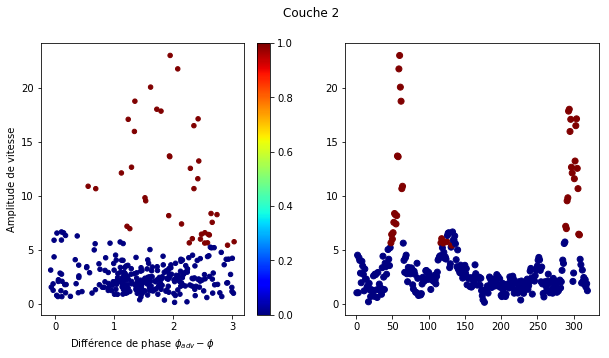

In [42]:
# Init the GMM
gmm2=GMM(n_components=K)

# Fit the GMM onto the dataset
gmm2=gmm2.fit(D2)

# Get the posteriors
posts2=gmm2.predict_proba(D2)

# get the class maximising the posteriors (hard classif):
labels2=gmm2.predict(D2)

# Compute robustness of the classification
robust2=(np.max(posts2,axis=1)-1./K)*K/(K-1.)
Plist=[0,.33,.66,.9,.99,1];
row10=('Unlikely','As likely as not','Likely','Very Likely','Virtually certain')
robust_id2=np.digitize(robust2,Plist)-1

i_sample=np.random.randint(0,high=D2.shape[0],size=(1,))
print('\nPosteriors for 1 sample:',np.round(posts2[i_sample,:]*100,2),'in %')
print('Sum of the posteriors:',np.sum(posts2[i_sample,:]))
print('Class id of the sample:',labels2[i_sample])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sc2=plt.scatter(D2[:,0],D2[:,1],s=20,c=labels2,cmap='jet')
plt.colorbar(sc2)
plt.suptitle('Couche 2')
plt.xlabel('Différence de phase $\phi_{adv}-\phi$')
plt.ylabel('Amplitude de vitesse')
plt.subplot(1,2,2)
sc2=plt.scatter(n,Ur2,c=labels2,cmap='jet')


Posteriors for 1 sample: [[99.14  0.86]] in %
Sum of the posteriors: 0.9999999999999998
Class id of the sample: [0]


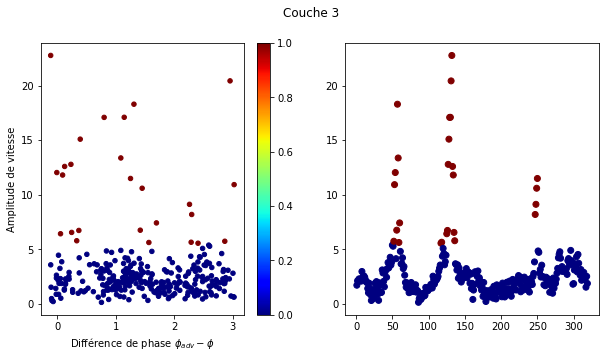

In [43]:
gmm3=GMM(n_components=K)

# Fit the GMM onto the dataset
gmm3=gmm3.fit(D3)


# Get the posteriors
posts3=gmm3.predict_proba(D3)

# get the class maximising the posteriors (hard classif):
labels3=gmm3.predict(D3)

# Compute robustness of the classification
robust3=(np.max(posts3,axis=1)-1./K)*K/(K-1.)
Plist=[0,.33,.66,.9,.99,1];
row10=('Unlikely','As likely as not','Likely','Very Likely','Virtually certain')
robust_id3=np.digitize(robust3,Plist)-1

i_sample=np.random.randint(0,high=D3.shape[0],size=(1,))
print('\nPosteriors for 1 sample:',np.round(posts3[i_sample,:]*100,2),'in %')
print('Sum of the posteriors:',np.sum(posts3[i_sample,:]))
print('Class id of the sample:',labels3[i_sample])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sc3=plt.scatter(D3[:,0],D3[:,1],s=20,c=labels3,cmap='jet')
plt.colorbar(sc3)
plt.suptitle('Couche 3')
plt.xlabel('Différence de phase $\phi_{adv}-\phi$')
plt.ylabel('Amplitude de vitesse')
plt.subplot(1,2,2)
sc3=plt.scatter(n,Ur3,c=labels3,cmap='jet')

Pour la couche 3 cette méthode fonctionne, mais pour les couches 1 et 2, plus proches de la surface elle est moins efficace. Les Kmeans sont donc dans ce cas à utiliser.

## Conclusion

Nous avons pu identifier le passage de tourbillons à un mouillage en détectant les anomalies de vitesse.

L'étude de la distribution de vitesse nous donne une idée approximative de la vitesse moyenne (vitesse d'advection des tourbillons), mais le fit des données ne permet une définition claire de cette vitesse. Nous avons donc effectuer un clustering en utilisant les vitesses et leur phase. Ceci permet l'identification des anomalies de vitesse et donc des tourbillons. L'utilisation de 3 cmusters a permis une définition plus précise de la vitesse moyenne. A partir de cette valeur la taille des tourbillons pourra être déduite.